In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn
import lightgbm as lgb 
import scipy.optimize as optimize

pd.set_option('use_inf_as_na', True)
from collections import Counter
import _pickle as cPickle

from tqdm import tqdm # to measure progress of for loops

/var/folders/sp/wlr6xm2979l8vx6kjh2z1dk00000gn/T/ipykernel_77651/4031544042.py:12: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('use_inf_as_na', True)


# Problem 1

## Random Forest

### Long term performance with Random Forest Classifier, optimal hyper-parameters, and optimal features

In [2]:
raw_data = pd.read_pickle(r'dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [3]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.025:
        return -1
    else:
        return 0

In [4]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [5]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()

In [6]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [7]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d:d+pd.DateOffset(months = 3)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 6):d+pd.DateOffset(months = 9)] for d in end_dates]

In [8]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [9]:
valid_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]

In [10]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [11]:
training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames] 

In [12]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    training_data[i] = training_data[i].copy()
    valid_data[i] = valid_data[i].copy()
    test_data[i] = test_data[i].copy()
    training_data[i][float_vars] = scaler.fit_transform(training_data[i][float_vars])
    valid_data[i][float_vars] = scaler.transform(valid_data[i][float_vars])
    test_data[i][float_vars] = scaler.transform(test_data[i][float_vars])

### Open and read the shap features over the holding period 2003 - 2018

In [13]:
with open(r'Random Forest Parameters/shap_features.pkl','rb') as f:
    shap_rf = cPickle.load(f)
with open(r'Random Forest Parameters/optimal_hyperparameters.pkl','rb') as f:
    opt_hyper_params_rf = cPickle.load(f)

In [14]:
# Convert shap_rf to a list of features
shap_rf_list = []
for feats in shap_rf:
    shap_rf_list.extend(list(feats))

# Find the 10 most common features
c = Counter(shap_rf_list)
c.most_common(10)

[('fcf_yield', 42),
 ('cf_yield', 41),
 ('oancfy', 41),
 ('oancfy_q', 39),
 ('fcf_csfhdq', 37),
 ('lt_ppentq', 37),
 ('evmq', 36),
 ('dprq', 36),
 ('oepsxy', 35),
 ('dvpspq', 35)]

In [15]:
# Choose 10 most common shap features to be the optimal features
opt_rf_feats = [val[0] for val in c.most_common(10)]

In [16]:
# Initialize the list of classifiers with the optimal hyperparameters
rf_classifiers = []

for hyp_par in opt_hyper_params_rf:
    rf_clf = RandomForestClassifier(**hyp_par)
    rf_classifiers.append(rf_clf)

In [17]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 39) for d in start_dates]

In [18]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 39)] for d in start_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [19]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [20]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][opt_rf_feats].values),columns=opt_rf_feats) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][opt_rf_feats].values),columns=opt_rf_feats) for i in range(len(start_dates)-1)]

In [21]:
opt_test_data[1]

,fcf_yield,cf_yield,oancfy,oancfy_q,fcf_csfhdq,lt_ppentq,evmq,dprq,oepsxy,dvpspq
0,-0.206398,-0.645950,-0.171431,-0.142220,-0.222443,-0.138036,0.080339,-0.042204,-0.093053,-0.595682
1,-0.420684,2.792597,0.852188,0.210787,-0.359797,-0.137840,-1.060025,-0.112661,-0.578317,-0.408904
2,-0.020692,-0.102749,-0.051488,-0.110094,-0.118421,-0.143237,0.013442,-0.006715,0.215752,-0.198778
3,0.049269,-0.199209,-0.200669,-0.110826,0.041014,-0.126797,0.011170,-0.030968,0.107470,-0.595682
4,0.006049,-0.332625,1.494588,1.340345,0.089421,-0.136787,0.018215,0.007137,0.307992,0.478292
...,...,...,...,...,...,...,...,...,...,...
1131,-0.062845,-0.275955,-0.011859,0.030989,-0.150327,-0.125497,-0.007114,0.091678,-0.133157,0.618376
1132,-0.036429,-0.386222,-0.195607,-0.156680,0.068950,-0.122519,0.014597,-0.023044,0.099449,-0.408904
1133,-0.242139,0.414694,-0.090863,0.021878,-0.311895,-0.146362,0.002207,-0.042204,-0.297586,-0.595682
1134,-0.032373,-0.453909,-0.213380,-0.163768,0.006329,-0.099544,0.015523,-0.042204,0.051323,-0.595682


In [22]:
x_rf = [1]
ret_rf = []

for i in tqdm(range(len(start_dates)-1)):
        rf_classifiers[i].fit(opt_training_data[i],training_labels[i])
        preds = rf_classifiers[i].predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret_rf.append(profit_i)
        num_names = len(opt_test_data[i])
        x_rf.append(x_rf[i] + (x_rf[i]/num_names)*profit_i)

100%|███████████████████████████████████████████| 56/56 [00:16<00:00,  3.40it/s]


## Gradient Boosting

### Long term performance with Gradient Boosting Classifier, and optimal shapley features

In [23]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.01:
        return -1
    else:
        return 0

In [24]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)

In [25]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()

### Open and read the shap features for the Gradient Boosting classifiers

In [26]:
with open(r'Gradient Boosting Parameters/shap_features_gb_clf_01.pkl','rb') as f:
    shap_gb = cPickle.load(f)


In [27]:
# Convert shap_gb to a list of features
shap_gb_list = []
for feats in shap_gb:
    shap_gb_list.extend(list(feats))

# Find the 10 most common features
c = Counter(shap_gb_list)
c.most_common(10)

[('fcf_yield', 47),
 ('cf_yield', 47),
 ('evmq', 42),
 ('lt_ppentq', 42),
 ('oancfy', 39),
 ('opmbdq', 38),
 ('rect_turnq', 38),
 ('rectq', 37),
 ('fcf_csfhdq', 37),
 ('oepsxy', 36)]

In [28]:
# Choose 10 most common shap features to be the optimal features
opt_gb_feats = [val[0] for val in c.most_common(10)]

### Open and gradient boosting classifiers with optimal hyperparameters

In [29]:
with open(r'Gradient Boosting Parameters/classifiers_gb_clf_01.pkl','rb') as f:
    gb_clfs = cPickle.load(f)

# add parameter to surpress warnings
for i in range(len(gb_clfs)):
    gb_clfs[i].set_params(verbose=-1)

# The list of gradient boosting classifiers with the optimal hyperparameters
gb_clfs

/Users/shri/miniconda3/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.3.0 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[LGBMClassifier(learning_rate=0.18000000000000002, min_data_in_leaf=1200,
                n_estimators=80, num_leaves=21,
                reg_lambda=4.1926760590611446e-05, verbose=-1),
 LGBMClassifier(learning_rate=0.06999999999999999, min_data_in_leaf=2000,
                n_estimators=20, num_leaves=18, reg_lambda=0.28156428865021,
                verbose=-1),
 LGBMClassifier(learning_rate=0.2, min_data_in_leaf=2400, n_estimators=60,
                num_leaves=12, reg_lambda=0.00949580168692767, verbose=-1),
 LGBMClassifier(learning_rate=0.08, min_data_in_leaf=800, n_estimators=90,
                num_leaves=11, reg_lambda=0.35501553792735624, verbose=-1),
 LGBMClassifier(learning_rate=0.05, min_data_in_leaf=2400, n_estimators=60,
                num_leaves=12, reg_lambda=1.1038244873745418e-05, verbose=-1),
 LGBMClassifier(learning_rate=0.15000000000000002, min_data_in_leaf=800,
                n_estimators=60, num_leaves=18, reg_lambda=5.2793165605788,
                verbose=-1),

In [30]:
gb_clfs[0]

LGBMClassifier(learning_rate=0.18000000000000002, min_data_in_leaf=1200,
               n_estimators=80, num_leaves=21,
               reg_lambda=4.1926760590611446e-05, verbose=-1)

In [31]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3 * i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 39) for d in start_dates]

In [32]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [33]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [34]:
opt_training_data = [t[opt_gb_feats] for t in training_data]
opt_test_data = [v[opt_gb_feats] for v in test_data]

In [35]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 39)] for d in start_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [36]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [37]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][opt_gb_feats].values),columns=opt_gb_feats) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][opt_gb_feats].values),columns=opt_gb_feats) for i in range(len(start_dates)-1)]

In [38]:
opt_test_data[1]

,fcf_yield,cf_yield,evmq,lt_ppentq,oancfy,opmbdq,rect_turnq,rectq,fcf_csfhdq,oepsxy
0,-0.206398,-0.645950,0.080339,-0.138036,-0.171431,0.030115,-0.020232,-0.186348,-0.222443,-0.093053
1,-0.420684,2.792597,-1.060025,-0.137840,0.852188,0.054635,-0.037180,-0.103132,-0.359797,-0.578317
2,-0.020692,-0.102749,0.013442,-0.143237,-0.051488,0.013209,28.472902,-0.191543,-0.118421,0.215752
3,0.049269,-0.199209,0.011170,-0.126797,-0.200669,0.026723,-0.030696,-0.163580,0.041014,0.107470
4,0.006049,-0.332625,0.018215,-0.136787,1.494588,0.038844,-0.024281,-0.071896,0.089421,0.307992
...,...,...,...,...,...,...,...,...,...,...
1131,-0.062845,-0.275955,-0.007114,-0.125497,-0.011859,0.010882,-0.025998,-0.137046,-0.150327,-0.133157
1132,-0.036429,-0.386222,0.014597,-0.122519,-0.195607,0.041883,-0.031240,-0.185974,0.068950,0.099449
1133,-0.242139,0.414694,0.002207,-0.146362,-0.090863,0.059763,-0.029572,-0.161034,-0.311895,-0.297586
1134,-0.032373,-0.453909,0.015523,-0.099544,-0.213380,0.022533,-0.025630,-0.189036,0.006329,0.051323


In [39]:
P_L_gb = []
x_gb = [1]
ret_gb = []

for i in tqdm(range(len(start_dates)-1)):
        gb_clfs[i].fit(opt_training_data[i],training_labels[i])
        pred_i = gb_clfs[i].predict(opt_test_data[i])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L_gb.append(profit_i)
        num_positions = len(pred_i)
        ret_gb.append((1.0/num_positions) * profit_i)
        x_gb.append(x_gb[i] + (x_gb[i]/num_positions) * profit_i)

100%|███████████████████████████████████████████| 56/56 [00:10<00:00,  5.44it/s]


### Plot the P/L curves and compute the Sharpe Ratios for all strategies

In [40]:
SPY = pd.read_pickle(r'SPY_cum_ret.pkl')
SPY = SPY.loc['2004-07-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)

SPY['random forest strategy'] = x_rf
SPY['gradient boosting strategy'] = x_gb

/var/folders/sp/wlr6xm2979l8vx6kjh2z1dk00000gn/T/ipykernel_77651/3282873245.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)


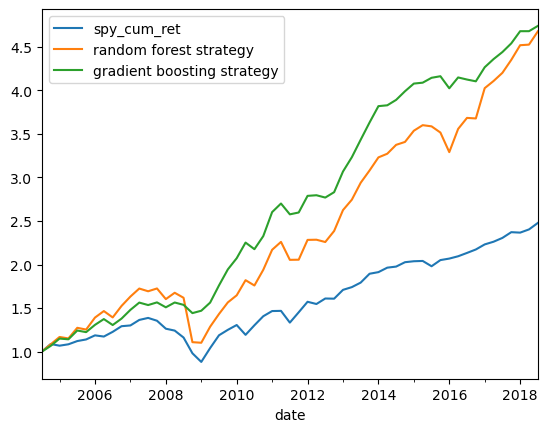

In [41]:
SPY.plot();

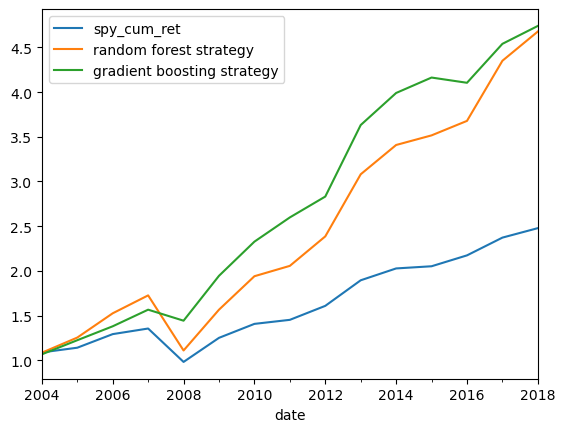

In [42]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [43]:
spy_mean_ret = (SPY['spy_cum_ret'] - 1).diff().mean()
spy_std = (SPY['spy_cum_ret'] - 1).diff().std()
print('SPY Sharpe Ratio: ',spy_mean_ret/spy_std)

strategy_mean_ret = (SPY['random forest strategy'] - 1).diff().mean()
strategy_std = (SPY['random forest strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Random Forest Strategy Sharpe Ratio    : ',strategy_sr)

strategy_mean_ret = (SPY['gradient boosting strategy'] - 1).diff().mean()
strategy_std = (SPY['gradient boosting strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Gradient Boosting Strategy Sharpe Ratio: ',strategy_sr)

SPY Sharpe Ratio:  0.6324646748042164
Random Forest Strategy Sharpe Ratio    :  0.8247800692842645
Gradient Boosting Strategy Sharpe Ratio:  1.1367787320017024


So we see that the final returns of our both our strategies are better than that of the SPY, with both above 4.5 at the end of our testing period.  

Further, the Sharpe Ratios of both our strategies our better, but it is evident that the Gradient Boosting classifier performed the best with a Sharpe Ratio of approximately 1.14.

# Problem 2
## Combining strategies by choosing weights

Next we will try to combine our existing strategies to find one with the best Sharpe Ratio.

For example if we naively choose weights:
- 0.5 for gradient boosting
- 0.5 for random forest strategy
- -0.1 for SPY (indicating that we are shorting it)

We obtain the following:

Hedge Strategy Sharpe Ratio:  1.0217132977126064


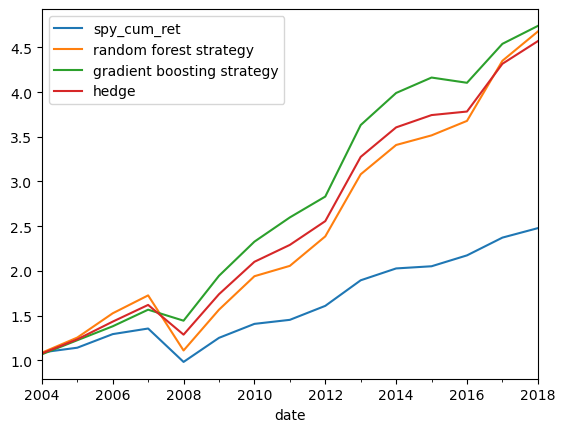

In [44]:
SPY['hedge'] = 0.5*SPY['gradient boosting strategy'] + 0.5*SPY['random forest strategy'] - 0.1 * (SPY['spy_cum_ret'] - SPY['spy_cum_ret'].iloc[0])
SPY.plot()

strategy_mean_ret = (SPY['hedge'] - 1).diff().mean()
strategy_std = (SPY['hedge'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Hedge Strategy Sharpe Ratio: ',strategy_sr)

However, we can try to find the weights that give us the best Sharpe ratio by using the optimize function in Scipy:

In [45]:
def weighted_hedge(weights):
    w1 = weights[0]
    w2 = weights[1]
    # w1 corresponds to the weight for the gradient boosted strategy
    # 1-w1 corresponds to the weight for the random forest strategy
    # w2 corresponds to the negative weight (i.e. shorting) for the SPY
    
    # Combine the strategies according to the weights
    SPY['hedge'] = w1 * SPY['gradient boosting strategy'] + (1-w1) * SPY['random forest strategy'] + w2 * (SPY['spy_cum_ret'] - SPY['spy_cum_ret'].iloc[0])

    # Compute the negative Sharpe ratio (As we need to minimize this)
    strategy_mean_ret = (SPY['hedge'] - 1).diff().mean()
    strategy_std = (SPY['hedge'] - 1).diff().std()
    strategy_sr = strategy_mean_ret/strategy_std
    return -strategy_sr

In [46]:
weighted_hedge([0.5, -0.1])

initial_guess = [0.5, -0.1]
result = optimize.minimize(weighted_hedge, initial_guess)

In [47]:
weighted_hedge([0.5, -0.1])
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.208154396931758
        x: [ 6.123e-01 -9.442e-01]
      nit: 10
      jac: [-2.980e-08 -5.513e-07]
 hess_inv: [[ 1.563e+00  1.760e+00]
            [ 1.760e+00  2.875e+00]]
     nfev: 39
     njev: 13

In [48]:
w1 = result.x[0]
w2 = result.x[1]
print(w1)
print(w2)

0.6122673948158399
-0.9441716133173984


Hedge Strategy Sharpe Ratio:  1.208154396931758


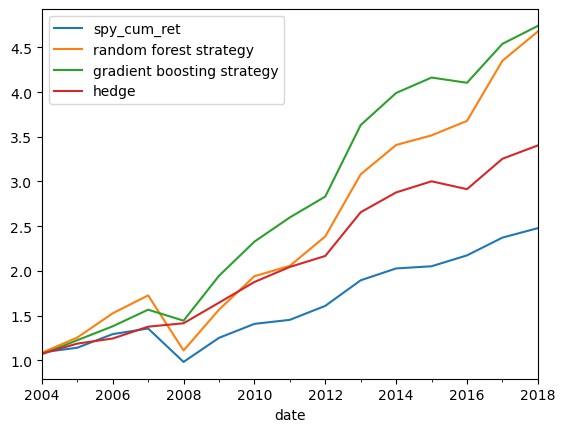

In [49]:
SPY['hedge'] = w1*SPY['gradient boosting strategy'] + (1-w1)*SPY['random forest strategy'] + w2 * (SPY['spy_cum_ret'] - SPY['spy_cum_ret'].iloc[0])
SPY.plot()

strategy_mean_ret = (SPY['hedge'] - 1).diff().mean()
strategy_std = (SPY['hedge'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Hedge Strategy Sharpe Ratio: ',strategy_sr)

So using our weights...